In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!apt-get -qq update
!apt-get -qq install -y iverilog

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package iverilog.
(Reading database ... 121852 files and directories currently installed.)
Preparing to unpack .../iverilog_11.0-1.1_amd64.deb ...
Unpacking iverilog (11.0-1.1) ...
Setting up iverilog (11.0-1.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [4]:
from pathlib import Path

OUT_DIR = Path("/content/day6_fix")
OUT_DIR.mkdir(parents=True, exist_ok=True)

baseline_v = r"""
module mac_baseline (
  input  wire        clk,
  input  wire        rst,
  input  wire        valid,
  input  wire [7:0]  a,
  input  wire [7:0]  b,
  input  wire [15:0] c,
  output reg  [15:0] y
);
  reg [7:0]  a_r;
  reg [7:0]  b_r;
  reg [15:0] c_r;
  reg [15:0] prod;

  // Baseline: always switching, even when valid is 0.
  // This is the "bad" design for power.
  always @(posedge clk) begin
    if (rst) begin
      a_r  <= 0;
      b_r  <= 0;
      c_r  <= 0;
      prod <= 0;
      y    <= 0;
    end else begin
      a_r  <= a;
      b_r  <= b;
      c_r  <= c;
      prod <= a_r * b_r;
      y    <= prod + c_r;
    end
  end
endmodule
"""

optimized_v = r"""
module mac_optimized (
  input  wire        clk,
  input  wire        rst,
  input  wire        valid,
  input  wire [7:0]  a,
  input  wire [7:0]  b,
  input  wire [15:0] c,
  output reg  [15:0] y
);
  reg [7:0]  a_r;
  reg [7:0]  b_r;
  reg [15:0] c_r;
  reg [15:0] prod;

  // Optimized: clock enable behavior.
  // If valid is 0, hold state, so multiplier inputs stay stable.
  always @(posedge clk) begin
    if (rst) begin
      a_r  <= 0;
      b_r  <= 0;
      c_r  <= 0;
      prod <= 0;
      y    <= 0;
    end else if (valid) begin
      a_r  <= a;
      b_r  <= b;
      c_r  <= c;
      prod <= a_r * b_r;
      y    <= prod + c_r;
    end
    // else: hold everything
  end
endmodule
"""

tb_v = r"""
`timescale 1ns/1ps

module tb;
  reg clk = 0;
  always #5 clk = ~clk;

  reg rst = 1;
  reg valid = 0;
  reg [7:0]  a = 0;
  reg [7:0]  b = 0;
  reg [15:0] c = 0;

  wire [15:0] y_base;
  wire [15:0] y_opt;

  mac_baseline  u_base(.clk(clk), .rst(rst), .valid(valid), .a(a), .b(b), .c(c), .y(y_base));
  mac_optimized u_opt (.clk(clk), .rst(rst), .valid(valid), .a(a), .b(b), .c(c), .y(y_opt));

  integer i;

  initial begin
    $dumpfile("baseline.vcd");
    $dumpvars(0, u_base);
  end

  initial begin
    #1;
    $dumpfile("optimized.vcd");
    $dumpvars(0, u_opt);
  end

  // Stimulus:
  // We keep changing a,b,c every cycle even when valid is 0.
  // That makes baseline toggle a lot and optimized stay quiet during invalid gaps.
  initial begin
    rst = 1;
    valid = 0;
    a = 0; b = 0; c = 0;

    repeat (5) @(posedge clk);
    rst = 0;

    for (i = 0; i < 400; i = i + 1) begin
      @(posedge clk);

      // valid pattern: 1 for 1 cycle, then 0 for 3 cycles (lots of idle time)
      if ((i % 4) == 0) valid <= 1'b1;
      else valid <= 1'b0;

      // always change inputs, even when valid is 0
      a <= $random;
      b <= $random;
      c <= $random;
    end

    repeat (10) @(posedge clk);
    $finish;
  end
endmodule
"""

(Path("mac_baseline.v")).write_text(baseline_v)
(Path("mac_optimized.v")).write_text(optimized_v)
(Path("tb.v")).write_text(tb_v)

print("Wrote mac_baseline.v, mac_optimized.v, tb.v")

Wrote mac_baseline.v, mac_optimized.v, tb.v


In [5]:
from pathlib import Path

tb_v = r"""
`timescale 1ns/1ps

module tb;
  reg clk = 0;
  always #5 clk = ~clk;

  reg rst = 1;
  reg valid = 0;
  reg [7:0]  a = 0;
  reg [7:0]  b = 0;
  reg [15:0] c = 0;

  wire [15:0] y;

  integer i;

  `ifdef USE_BASELINE
    mac_baseline dut(.clk(clk), .rst(rst), .valid(valid), .a(a), .b(b), .c(c), .y(y));
    initial begin
      $dumpfile("baseline.vcd");
      $dumpvars(0, dut);
    end
  `else
    mac_optimized dut(.clk(clk), .rst(rst), .valid(valid), .a(a), .b(b), .c(c), .y(y));
    initial begin
      $dumpfile("optimized.vcd");
      $dumpvars(0, dut);
    end
  `endif

  initial begin
    rst = 1;
    valid = 0;
    a = 0; b = 0; c = 0;

    repeat (5) @(posedge clk);
    rst = 0;

    for (i = 0; i < 400; i = i + 1) begin
      @(posedge clk);

      if ((i % 4) == 0) valid <= 1'b1;
      else valid <= 1'b0;

      a <= $random;
      b <= $random;
      c <= $random;
    end

    repeat (10) @(posedge clk);
    $finish;
  end
endmodule
"""
Path("tb.v").write_text(tb_v)
print("Rewrote tb.v")

Rewrote tb.v


In [6]:
%%bash
set -e
ls -lh *.v

rm -f baseline.vcd optimized.vcd sim_baseline sim_opt

iverilog -g2012 -o sim_baseline -DUSE_BASELINE tb.v mac_baseline.v
vvp sim_baseline

iverilog -g2012 -o sim_opt tb.v mac_optimized.v
vvp sim_opt

ls -lh baseline.vcd optimized.vcd

-rw-r--r-- 1 root root 650 Feb 14 00:42 mac_baseline.v
-rw-r--r-- 1 root root 700 Feb 14 00:42 mac_optimized.v
-rw-r--r-- 1 root root 957 Feb 14 00:42 tb.v
VCD info: dumpfile baseline.vcd opened for output.
VCD info: dumpfile optimized.vcd opened for output.
-rw-r--r-- 1 root root 57K Feb 14 00:43 baseline.vcd
-rw-r--r-- 1 root root 35K Feb 14 00:43 optimized.vcd


In [7]:
from collections import defaultdict
import re
import pandas as pd

def count_vcd_toggles(vcd_path: str):
  id_to_name = {}
  toggles = defaultdict(int)
  last_val = {}

  header_done = False
  in_dumpvars = False

  with open(vcd_path, "r", errors="ignore") as f:
    for line in f:
      line = line.strip()
      if not line:
        continue

      if line.startswith("$var"):
        parts = line.split()
        # $var wire 1 ! clk $end
        vcd_id = parts[3]
        name = parts[4]
        id_to_name[vcd_id] = name
        continue

      if line.startswith("$dumpvars"):
        in_dumpvars = True
        continue
      if in_dumpvars and line.startswith("$end"):
        in_dumpvars = False
        header_done = True
        continue

      if not header_done:
        continue

      # scalar change: 0!, 1!, x!, z!
      m = re.match(r"^([01xz])(.+)$", line)
      if m:
        val = m.group(1)
        vcd_id = m.group(2)
        prev = last_val.get(vcd_id)
        if prev is not None and prev != val:
          toggles[vcd_id] += 1
        last_val[vcd_id] = val
        continue

      # vector change: b1010 #
      if line.startswith("b"):
        bits, vcd_id = line[1:].split()
        prev = last_val.get(vcd_id)
        if prev is not None and prev != bits:
          toggles[vcd_id] += 1
        last_val[vcd_id] = bits
        continue

  total = sum(toggles.values())
  by_signal = []
  for vcd_id, name in id_to_name.items():
    by_signal.append({"signal": name, "toggles": toggles.get(vcd_id, 0)})
  by_signal_df = pd.DataFrame(by_signal).sort_values("toggles", ascending=False)

  return total, by_signal_df

base_total, base_df = count_vcd_toggles("baseline.vcd")
opt_total, opt_df = count_vcd_toggles("optimized.vcd")

summary = pd.DataFrame([
  {"design": "baseline", "total_toggles": int(base_total)},
  {"design": "optimized", "total_toggles": int(opt_total)},
])

reduction = 0.0
if base_total > 0:
  reduction = (base_total - opt_total) * 100.0 / base_total

summary["percent_reduction_vs_baseline"] = [0.0, reduction]

print("Baseline total toggles:", base_total)
print("Optimized total toggles:", opt_total)
print("Percent reduction:", reduction)

summary_path = OUT_DIR / "day6_toggle_summary_fixed.csv"
by_sig_path = OUT_DIR / "day6_toggles_by_signal_fixed.csv"
summary.to_csv(summary_path, index=False)

both_df = pd.concat([
  base_df.assign(design="baseline"),
  opt_df.assign(design="optimized"),
], ignore_index=True)
both_df.to_csv(by_sig_path, index=False)

print("Saved:", summary_path)
print("Saved:", by_sig_path)
summary

Baseline total toggles: 4219
Optimized total toggles: 2719
Percent reduction: 35.5534486845224
Saved: /content/day6_fix/day6_toggle_summary_fixed.csv
Saved: /content/day6_fix/day6_toggles_by_signal_fixed.csv


,design,total_toggles,percent_reduction_vs_baseline
0,baseline,4219,0.000000
1,optimized,2719,35.553449


FileNotFoundError: [Errno 2] No such file or directory: 'figures/rtl_toggle_comparison.png'

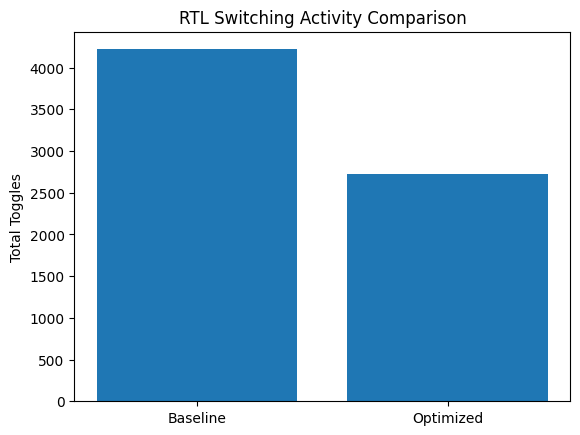

In [8]:
import matplotlib.pyplot as plt

labels = ["Baseline", "Optimized"]
values = [4219, 2719]

plt.figure()
plt.bar(labels, values)
plt.title("RTL Switching Activity Comparison")
plt.ylabel("Total Toggles")
plt.savefig("figures/rtl_toggle_comparison.png", dpi=300)
plt.show()